This notebook illustrates the workflow this repo provides

We will do key imports up here. Modules from `src` that are pivotal to stages throughout the WF will be imported in their respective sections.

In [1]:
import numpy as np
import pandas as pd
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path

# get from /notebooks/ to /src/
src_path = Path("..", "src")
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

Here we declare some key parameters that will dictate the rest of the workflow. 

In [2]:
num_classes = 3
# the following is specific to a 3 class model. it will be different for 5
down_margin = 0.005
up_margin = 0.008

lag_factor = 5
test_size = 0.25

data = "BTCUSDT_1h_2020_2024_final.csv"

from session_info import SessionInfo

session = SessionInfo(
    data, num_classes, lag_factor, test_size,
    up_margin = up_margin, down_margin = down_margin
)

Load data in and do any required cleaning

In [3]:
df = pd.read_csv("./../input/" + data)
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
#df.drop(['base_asset_volume', 'no_trades', 'taker_buy_vol', 'taker_buy_base_asset_vol'], axis=1, inplace=True)

print(df.columns)
print(df.shape)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'base_asset_volume',
       'no_trades', 'taker_buy_vol', 'taker_buy_base_asset_vol'],
      dtype='object')
(43817, 10)


**Feature Engineering and Preprocessing**
***

Add the target variable and do any feature engineering.

In [4]:
from add_features import add_features

cols = add_features(df, session)

df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow', drop_first=True)
df.dropna()


for lag in range(1, lag_factor+1):
    for col in cols:
        newcol = np.zeros(df.shape[0]) * np.nan
        newcol[lag:] = df[col].values[:-lag]
        df.insert(len(df.columns), "{0}_{1}".format(col, lag), newcol)

df = df.dropna()

# move the jump and target variable (jump_tmr) to the end
df = pd.get_dummies(df, columns=['jump'], prefix='jump', drop_first=True)
df = df[[col for col in df.columns if col not in ['next_jump']] + ['next_jump']]

Separate the data into features and the target variable, and split it into training and testing sets.

In [5]:
from utility_functions import get_jump_lookup

jump_lookup = get_jump_lookup(num_classes=num_classes)


X = df.drop(['date', 'next_jump'], axis=1).copy()
y = df['next_jump'].copy()
y = y.map(jump_lookup)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

time = df['date'].copy()
train_timestamp, test_timestamp = time[:len(y_train)], time[len(y_train):]

**XGBoost Optimisation**
***

From the training data, we now find CV'd optimal parameters using `Optuna`. Specifically, we will use a stepwise optimisation algorithm, that optimises predetermined groups of parameters at a time before other groups to save computation time.

We also use an evaluation metric from `eval_metrics.py`, which will be passed into `stepwise_optimisation`. Custom evaluation metrics can of course be added to `eval_metrics.py` and passed in. See the file for more.

In [6]:
from optimise_xgb import stepwise_optimisation
import eval_metrics

eval_metric = eval_metrics.f1_weighted_eval

params = stepwise_optimisation(X_train, y_train, 3, eval_metric)

====== Optimising Group 1 ======
STUDY NAME:  xgboost
-------------------------------------------------------
EVALUATION METRIC:  f1_weighted_eval
-------------------------------------------------------
BEST CV SCORE:  0.4421094
-------------------------------------------------------
OPTIMAL GROUP - 1 PARAMS:  {'max_depth': 21, 'min_child_weight': 17.096825780771223}
-------------------------------------------------------
BEST TRIAL FrozenTrial(number=440, state=TrialState.COMPLETE, values=[0.4421094], datetime_start=datetime.datetime(2025, 1, 23, 11, 57, 20, 959711), datetime_complete=datetime.datetime(2025, 1, 23, 11, 57, 30, 361412), params={'max_depth': 21, 'min_child_weight': 17.096825780771223}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.4421094, 1: 0.4436256, 2: 0.442991, 3: 0.44254619999999995, 4: 0.442382, 5: 0.4435868, 6: 0.4445568, 7: 0.4443122, 8: 0.44416500000000003, 9: 0.4437308000000001}, distributions={'max_depth': IntDistribution(high=30, log=False, low=

**Run Backtests**
***

With our optimal parameters, it is time to pick a strategy and backtest it.

Strategies can be added to `strategies.py`. See the file for more info

In [7]:
# define a model trainer - this will basically be the same for 
# all wf's, but make sure the eval_metric from above is used
def model_trainer(X_train, y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=params['num_boost_round'],
        #obj='multi:softprob',
        custom_metric=eval_metric
    )

    return model

from backtest import Backtest
import strategies

backtest = Backtest(
    model_trainer, X_train, y_train, X_test, y_test, train_timestamp, test_timestamp, num_classes,
    starting_capital=500_000, commission=0.0002
)

strategy = strategies.all_in_3_class

In [8]:
bt_results = backtest.run_backtest(strategy, retrain=True, train_frequency=24*21, progress_bar=True)

-------------------- Starting backtest --------------------

Progress: |██████████████████████████████████████████████████| 100.0% Complete


-------------------- Backtest Complete! --------------------


**Analysing Backtest results**
***

We use graphical approaches as well as financial metrics/analytics to assess the results of our test

In [19]:
from backtest_metrics import plot_backtest

plot_backtest(bt_results)

In [20]:
from backtest_metrics import print_backtest_metrics

print_backtest_metrics(bt_results)


================ Backtest  Metrics ================

---------------- Test  Information ----------------

Start:                          2024-01-02 10:00:00
End:                            2025-01-01 08:20:00
Duration:                       364 days, 22 hours, 20 mins, 0 seconds

---------------- Strategy Metrics -----------------

Strategy:                       all_in_3_class

Exposure:                       0.23838337709784221
Initial Equity:                 500000.00 
Equity High:                    885079.12 
Equity Low:                     499900.34 
Final Equity:                   858924.93 

Return (ann.) [%]:              63.35     
Buy & Hold Return (ann.) [%]:   42.11     
Volatility (ann.) [%]:          41.05     
Sharpe Ratio (R=4.00%): 1.54      

----------------- Trade  Metrics ------------------

Num. Trades:                    28        
Win Rate [%]:                   14467.86  
Avg. Trade [%]:                 4.65      
Avg. Trade Duration:            74.690051548

In [22]:
model = model_trainer(
    pd.concat([X_train, X_test]), pd.concat([y_train, y_test])
)

<Axes: >

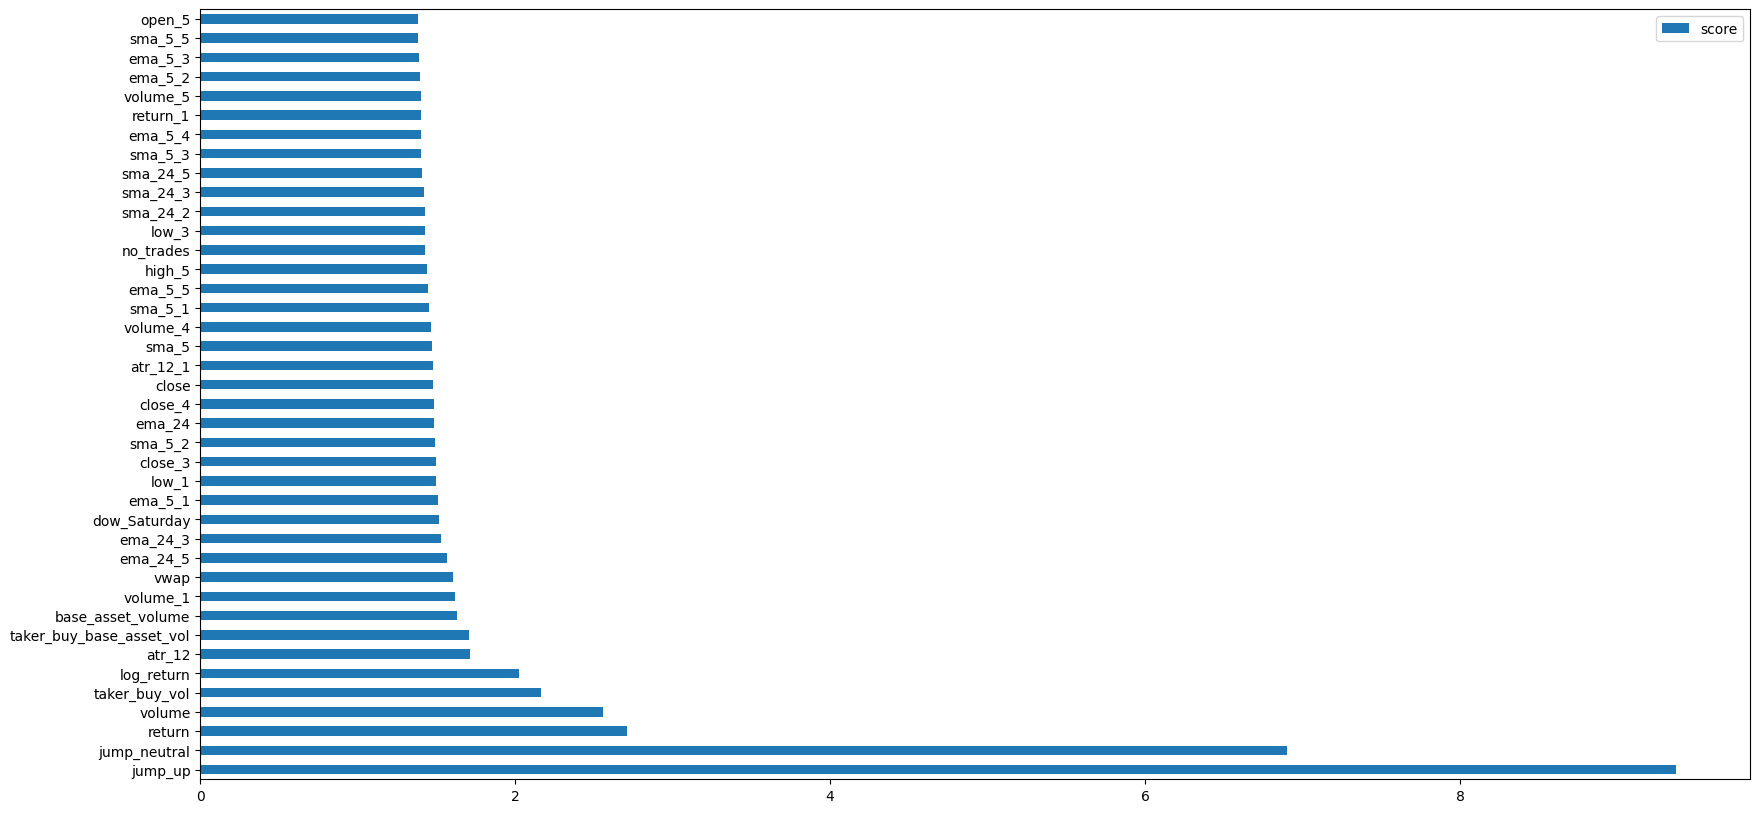

In [27]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features